In [ ]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.utils.transforms import unnormalize, normalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs

#from BOClass import Models, Plotting, PoolObjectives
from boclass_query import Models, Plotting, PoolObjectives

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
all_data = pd.read_csv('all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
data01 = all_data[:15]
data2A = all_data[15:30]
data2B = all_data[30:45]
data2C = all_data[45:60]
data3A = all_data[60:75]
data3B = all_data[75:90]
data3C = all_data[90:105]
# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
set_dataB = pd.concat([data01, data2B, data3B], axis=0,ignore_index=True)
set_dataC = pd.concat([data01, data2C, data3C], axis=0,ignore_index=True)


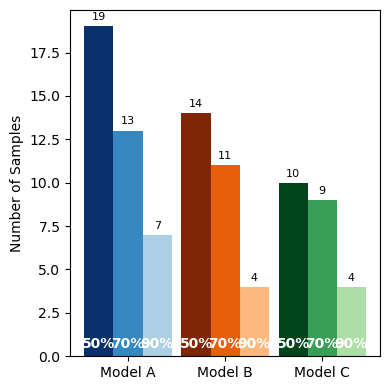

In [3]:
# Check Data
thresholds = [0.5, 0.7, 0.9]

# Calculate counts for each threshold for each model
counts_A = [ (set_dataA['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_B = [ (set_dataB['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_C = [ (set_dataC['yield product'] > thresh).sum().item() for thresh in thresholds ]

model_counts = [counts_A, counts_B, counts_C]
model_names = ['ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()


In [4]:
random_seed = 5
batch_size = 5

# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)


x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)


random.seed(5)
random_indices = random.sample(range(x_all.shape[0]), batch_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]

# Remove x_train rows from x_inputs
# Convert x_train to numpy for comparison
x_train_np = x_train.cpu().numpy()
# Find all rows in x_inputs that are not in x_train
mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]
query = PoolObjectives(x_input_new, y_output_new ,yvar_output_new)
# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)

# Step 2: Initialize Plotting class
# variable_combinations = [('time', 'sulf', 'anly'), ('time', 'anly', 'sulf'), ('sulf', 'anly', 'time')]
# plotting = Plotting(gp_model, variable_combinations=variable_combinations)

# combination = variable_combinations[0]
# minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)



In [5]:
def BO_loop(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = gp_model.regular_candidates(x_all)
        #print(used_id)
        x_all = query.get_new_pool(used_id)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


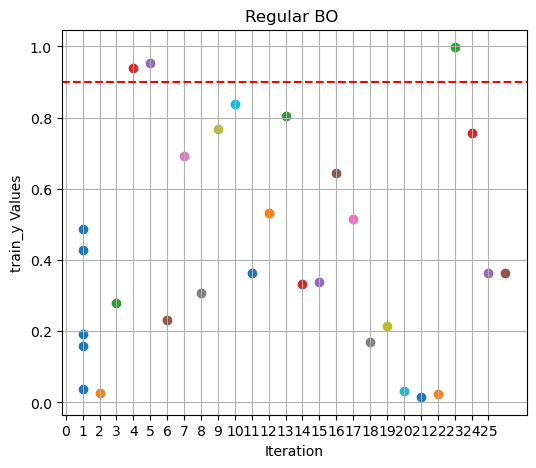

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([201., 145.,  75.,  79.])
Iteration 3: tensor([68., 58., 85., 65.])
Iteration 4: tensor([561., 133.,  87.,  67.])
Iteration 5: tensor([430., 139.,  95.,  87.])
Iteration 6: tensor([528., 104.,  79.,  83.])
Iteration 7: tensor([509., 104.,  89.,  86.])
Iteration 8: tensor([503.,  58.,  81.,  62.])
Iteration 9: tensor([486., 104.,  88.,  86.])
Iteration 10: tensor([313., 106.,  98.,  88.])
Iteration 11: tensor([471., 104.,  79.,  75.])
Iteration 12: tensor([468., 104.,  85.,  54.])
Iteration 13: tensor([408., 104.,  90.,  71.])
Iteration 14: tensor([333.,  58.,  89.,  61.])
Iteration 15: tensor([330.,  58.,  79.,  75.])
Iteration 16: tensor([260., 104.,  80.,  38.])
Iteration 17: tensor([153., 104.,  75.,  57.])
Iteration 18: tensor([581.,  95.,  87.,  44.])
Iteration 19: tensor([543., 145.,  79.,  88.])
Iteration 20: tensor([505.,  45.,  99.,  53.])
Iteration 21: tensor([466.,  45.,  85.,  70.])
Iteration 22: tensor([429.

In [6]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

iterations = 25

gp_modelBO, train_nxBO, train_yBO, train_yvarBO = BO_loop(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xBO = unnormalize(train_nxBO, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelBO, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = 1
split_data = [train_yBO[:batch_size]] + [
    train_yBO[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]

split_datax = [train_xBO[:batch_size]] + [
    train_xBO[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Regular BO ')
plt.xticks(range(0, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



In [7]:
def BO_batch_loop(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = gp_model.regular_candidates(x_all, batch_size=5)
        #print(used_id)
        x_all = query.get_new_pool(used_id)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


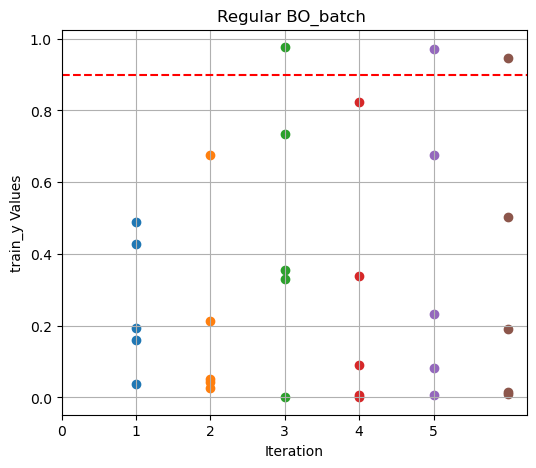

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([268., 133.,  83.,  74.])
Iteration 3: tensor([545., 133.,  96.,  82.])
Iteration 4: tensor([423., 137.,  94.,  58.])
Iteration 5: tensor([569., 137.,  99.,  65.])
Iteration 6: tensor([600., 137.,  93.,  56.])


In [8]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

iterations = 5

gp_modelBO_batch, train_nxBO_batch, train_yBO_batch, train_yvarBO_batch = BO_batch_loop(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xBO_batch = unnormalize(train_nxBO_batch, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelBO_batch, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = 5
split_data = [train_yBO_batch[:batch_size]] + [
    train_yBO_batch[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]

split_datax = [train_xBO_batch[:batch_size]] + [
    train_xBO_batch[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Regular BO_batch ')
plt.xticks(range(0, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



In [9]:
def BBO_loop(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.batch_candidates(batch_size=5)#.drop(columns=['cluster'])
        print(new_candidates)
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)
        # print(used_id)
        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


         time        temp       sulf        anly
0  406.510010  163.580002  89.110001  100.000000
1  381.640015  128.699997  79.470001  100.000000
2  250.750000  165.550003  79.570000   78.209999
3   43.889999  165.369995  91.790001  100.000000
4   30.000000  142.929993  77.699997  100.000000
         time    temp    sulf        anly
0  406.239990   25.27   89.93   97.599998
1  372.679993  170.00  100.00   84.430000
2  383.890015  170.00   75.00   95.199997
3  384.049988  170.00  100.00  100.000000
4  538.330017  170.00  100.00   97.900002
         time        temp       sulf       anly
0  402.010010  142.610001  99.339996  74.599998
1  361.529999  170.000000  87.959999  77.180000
2  355.429993  140.309998  91.870003  78.089996
3  420.940002  170.000000  95.589996  72.139999
4  344.839996  170.000000  96.599998  79.900002
         time        temp       sulf        anly
0  362.440002   47.740002  95.459999  100.000000
1  368.910004  170.000000  96.050003  100.000000
2  404.829987   51.

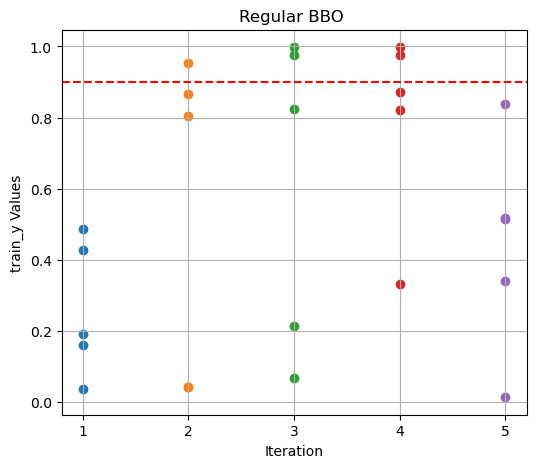

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([430., 139.,  95.,  87.])
Iteration 3: tensor([353., 145.,  94.,  66.])
Iteration 4: tensor([391., 145.,  97.,  35.])
Iteration 5: tensor([313., 106.,  98.,  88.])


In [10]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

iterations = 5

gp_modelBBO, train_nxBBO, train_yBBO, train_yvarBBO = BBO_loop(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xBBO = unnormalize(train_nxBBO, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelBBO, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yBBO[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xBBO[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]


# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Regular BBO ')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



In [11]:
def BO_loop_q1(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all)
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.batch_candidates(batch_size=1)#.drop(columns=['cluster'])
        print(new_candidates)
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)
        # print(used_id)
        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar

         time        temp       sulf       anly
0  334.459991  145.839996  78.919998  92.220001
         time        temp       sulf       anly
0  366.769989  153.470001  98.900002  72.839996
         time        temp       sulf   anly
0  356.720001  169.259995  89.309998  71.75
         time    temp       sulf       anly
0  377.630005  146.75  95.230003  95.110001
         time        temp       sulf       anly
0  383.820007  147.639999  94.339996  85.989998
         time        temp       sulf       anly
0  381.950012  146.949997  94.919998  97.639999
         time        temp       sulf       anly
0  382.420013  156.279999  96.540001  96.360001
         time        temp       sulf   anly
0  381.950012  166.690002  96.010002  99.07
         time        temp       sulf       anly
0  380.299988  151.119995  98.330002  97.599998
         time        temp       sulf       anly
0  194.580002  163.009995  95.870003  57.150002
         time        temp       sulf   anly
0  382.140015  144.5

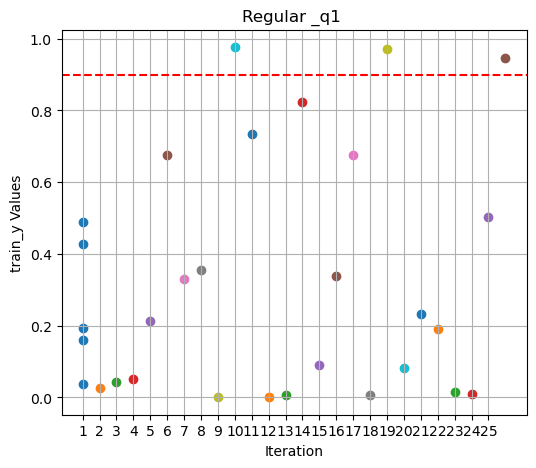

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([201., 145.,  75.,  79.])
Iteration 3: tensor([ 41., 148.,  77.,  84.])
Iteration 4: tensor([471., 139.,  75.,  98.])
Iteration 5: tensor([543., 145.,  79.,  88.])
Iteration 6: tensor([268., 133.,  83.,  74.])
Iteration 7: tensor([336., 106.,  86.,  65.])
Iteration 8: tensor([555.,  58.,  98.,  72.])
Iteration 9: tensor([552.,  71.,  75.,  40.])
Iteration 10: tensor([545., 133.,  96.,  82.])
Iteration 11: tensor([476., 138.,  91.,  56.])
Iteration 12: tensor([552.,  71.,  75.,  40.])
Iteration 13: tensor([334.0000,  70.0000,  90.0000,  72.0000])
Iteration 14: tensor([423., 137.,  94.,  58.])
Iteration 15: tensor([313.0000, 119.0000,  96.0000,  58.0000])
Iteration 16: tensor([185., 148.,  85.,  44.])
Iteration 17: tensor([268., 133.,  83.,  74.])
Iteration 18: tensor([334.0000,  70.0000,  90.0000,  72.0000])
Iteration 19: tensor([569., 137.,  99.,  65.])
Iteration 20: tensor([347.,  62.,  91.,  44.])
Iteration 21: tensor(

In [18]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

iterations = 25

gp_model_q1, train_nx_q1, train_y_q1, train_yvar_q1 = BO_loop_q1(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_x_q1 = unnormalize(train_nx_q1, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_model_q1, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = 1
split_data = [train_yBO_batch[:batch_size]] + [
    train_yBO_batch[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]

split_datax = [train_xBO_batch[:batch_size]] + [
    train_xBO_batch[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]
# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Regular _q1 ')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



<BarContainer object of 4 artists>

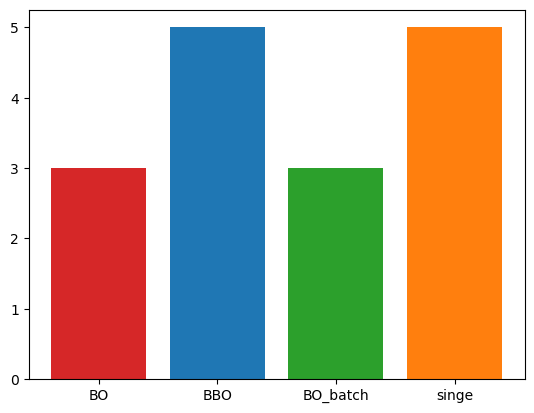

In [19]:
idsBO = (train_yBO > 0.9).nonzero(as_tuple=True)[0].tolist()
idsBBO = (train_yBBO > 0.9).nonzero(as_tuple=True)[0].tolist()
idsBO_batch = (train_yBO_batch > 0.9).nonzero(as_tuple=True)[0].tolist()
idsBO_q1 = (train_y_q1 > 0.9).nonzero(as_tuple=True)[0].tolist()
compare = [idsBO, idsBBO, idsBO_batch, idsBO_q1] 

# plt.bar(['Random', 'Model A', 'Model B', 'Model C'], [len(ids_random), len(idsA), len(idsB), len(idsC)], color=['tab:red','tab:blue', 'tab:orange', 'tab:green'])
plt.bar(['BO', 'BBO','BO_batch', 'singe'], [len(idsBO), len(idsBBO),len(idsBO_batch), len(idsBO_q1)], color=['tab:red','tab:blue','tab:green', 'tab:orange'])